<a href="https://colab.research.google.com/github/luisaheise/Trainee_DS/blob/master/DSTrainee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Web Scrapping

Como primeira etapa, foi feita a extração dos dados dos dados so site https://scrapethissite.com/pages/forms/?.
Entrando no site é possível perceber que ele dispõe de paginação, mais precisamente, são 24 páginas contendo os dados em questão. 
Dessa forma, foram feitos multiplas requisições alterando na query do endereço a página desejada.

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [3]:
URL = 'https://scrapethissite.com/pages/forms/?'

In [4]:
def get_raw_site(URL):
  """
  Retorna um objeto 'soup' de uma página web

  Keyword arguments:
    - URL: string contendo a url do site

  Outputs:
    - soup: objeto soup referente à página web
  """
  raw_site = requests.get(URL)
  status = raw_site.status_code
  assert  status == 200, f"Não foi possível estabelecer o site: status {status}"
  soup = BeautifulSoup(raw_site.text, 'html.parser')
  return soup

In [5]:
def soup_to_df(soup):
  """
  Extrai a tabela do objeto soup, transformando-a em um Data Frame do pandas

  Keyword arguments:
    - soup: objeto soup referente à página web

  Outputs:
    - df: Data Frame contendo a tabela extraída do objeto soup
  """
  table = soup.find('table')
  titles = table.find_all('th')
  titles = [title.text.strip() for title in titles]
  table_rows = table.find_all('tr')
  lines = []
  for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td] 
    if not(all(t == None for t in row)): 
      lines.append(row)
  df = pd.DataFrame(lines, columns=titles)
  return df

Utilizando as funções acima, foi extraído o data frame que contem os dados de interesse.

In [6]:
hockey_df = pd.DataFrame()
for i in range(1,25):
  url = f"{URL}page_num={i}"
  raw_site = get_raw_site(url)
  interm = soup_to_df(raw_site)
  hockey_df = hockey_df.append(interm)

## Análise e Visualização de Dados

Os dados extraídos na etapa anterior


In [7]:
hockey_df.to_csv("hockey.csv")
hockey_df.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Boston Bruins,1990,44,24,,0.55,299,264,35
1,Buffalo Sabres,1990,31,30,,0.388,292,278,14
2,Calgary Flames,1990,46,26,,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,,0.425,273,298,-25


In [8]:
hockey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 6
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Team Name           582 non-null    object
 1   Year                582 non-null    object
 2   Wins                582 non-null    object
 3   Losses              582 non-null    object
 4   OT Losses           582 non-null    object
 5   Win %               582 non-null    object
 6   Goals For (GF)      582 non-null    object
 7   Goals Against (GA)  582 non-null    object
 8   + / -               582 non-null    object
dtypes: object(9)
memory usage: 45.5+ KB


Como pode ser visto, os dtypes estão incorretos. Arrumando isso:

In [9]:
hockey_df = hockey_df.astype({"Year": int, "Wins": int, "Losses": int, "Win %": float, "Goals For (GF)": int, "Goals Against (GA)": int, "+ / -": int})

In [10]:
hockey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 6
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Team Name           582 non-null    object 
 1   Year                582 non-null    int64  
 2   Wins                582 non-null    int64  
 3   Losses              582 non-null    int64  
 4   OT Losses           582 non-null    object 
 5   Win %               582 non-null    float64
 6   Goals For (GF)      582 non-null    int64  
 7   Goals Against (GA)  582 non-null    int64  
 8   + / -               582 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 45.5+ KB


Pronto, agora está certo

Importando os dados fornecidos

In [13]:
espn = pd.read_csv(r"DataSet ESPN.csv")

In [14]:
espn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               290 non-null    int64  
 1   Team                     290 non-null    object 
 2   Home Games               290 non-null    int64  
 3   Home Total               290 non-null    object 
 4   Home Average             290 non-null    object 
 5   Road Games               290 non-null    int64  
 6   Road Average             290 non-null    object 
 7   Overall Games            290 non-null    int64  
 8   Overall Average          290 non-null    object 
 9   Year                     290 non-null    int64  
 10  Save Percentage          290 non-null    float64
 11  Penalty Minutes          290 non-null    int64  
 12  Penalty Minutes Against  290 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 29.6+ KB


In [15]:
espn.head()

,Unnamed: 0,Team,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against
0,0,Montreal Canadiens,41,"824,308","20,105",41,"16,013",82,"18,059",2001,0.899,1020,1294
1,1,Detroit Red Wings,41,"819,795","19,995",41,"17,889",82,"18,942",2001,0.909,1082,1072
2,2,Philadelphia Flyers,41,"802,595","19,575",41,"17,182",82,"18,378",2001,0.903,1183,1332
3,3,St Louis Blues,41,"800,319","19,519",41,"16,898",82,"18,209",2001,0.899,1345,1366
4,4,Toronto Maple Leafs,41,"789,567","19,257",41,"17,172",82,"18,215",2001,0.908,1430,1243


Alguns valores numericos estão com o separador decimal como vírgula. Vamos arrumar isso:

In [16]:
def arrumar_decimal(series, column_prob):
  if series.name in column_prob:
    if series.dtype == 'object':
      series = series.replace(regex={r',': '.'})
    series = pd.to_numeric(series, errors='coerce')
  return series

In [17]:
column_prob= ['Home Total', 'Home Average', 'Road Average', 'Overall Average']
espn = espn.apply(lambda x: arrumar_decimal(x, column_prob))

Como pode ser visto, as colunas "chaves", ou seja, aquelas que servem de referência para o merge entre o dataset fornecido e o extraído são 'Year' e 'Team'.
Fazendo esse merge, temos:

In [18]:
espn['id'] = espn.apply(lambda x: str(x['Team']) + str(x['Year']), axis = 1)
hockey_df['id'] = hockey_df.apply(lambda x: str(x['Team Name']) + str(x['Year']), axis = 1)

In [19]:
hockey_completo = hockey_df.set_index('id').combine_first(espn.set_index('id')).reset_index()

In [20]:
hockey_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       635 non-null    object 
 1   + / -                    582 non-null    float64
 2   Goals Against (GA)       582 non-null    float64
 3   Goals For (GF)           582 non-null    float64
 4   Home Average             290 non-null    float64
 5   Home Games               290 non-null    float64
 6   Home Total               290 non-null    float64
 7   Losses                   582 non-null    float64
 8   OT Losses                582 non-null    object 
 9   Overall Average          290 non-null    float64
 10  Overall Games            290 non-null    float64
 11  Penalty Minutes          290 non-null    float64
 12  Penalty Minutes Against  290 non-null    float64
 13  Road Average             290 non-null    float64
 14  Road Games               2

Agora que o dataset está completo, podemos começar a análise, vamos importar outras bibliotecas necessárias:

In [21]:
from scipy import stats
import statsmodels.api as sm
import numpy as np
import matplotlib as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Vamos começar com uma função ṕara simplificar as nossas análises univariadas. <br>
Uma coisa que pode ser verificada já de início é que as nossas features não são linearmente independentes, isso é claro, pois porcentagem de vitória pode ser obtida com derrotas, jogos fora de casa e jogos em casa, por exemplo.

In [22]:
def univariada(series):
  """
  Calcula medidas descritivas e mostra a distribuição dos dados

  Keyword arguments:
    - series: coluna de um Dataframe
  """ 
  if np.issubdtype(series.dtype, np.number):
    series_df = series
    series = np.array(series.dropna())
    nobs, minmax, media, variancia_amostral, assimetria_enviesada, curtose_enviesada   = stats.describe(series)
    curtose_amostral = stats.kurtosis(series, bias=False)
    assimetria_amostral = stats.skew(series, bias=False)
    normalizado = (series - media)/(variancia_amostral**0.5)
    _, pvalue_normal = stats.kstest(normalizado, 'norm')
    p25, p50, p75, p90 = np.percentile(series, 25), np.percentile(series, 50), np.percentile(series, 75), np.percentile(series, 90)
    print("Resumo:")
    print(f"Número de observações não nulas: {nobs} | Média: {media} | Desvio Padrão: {variancia_amostral**0.5} | Assimetria: {assimetria_amostral} | Curtose: {curtose_amostral}")
    print(f"Mínimo: {minmax[0]} | Primeiro Quartil: {p25} | Mediana: {p50} | Terceiro Quartil: {p75} | Percentil 90: {p90} | Máximo: {minmax[1]}")
    if pvalue_normal < 0.05:
     print("H0 rejeitado: há evidência de que a distribuição não é normal")
    else:
      print("H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal")
    print(f"P-valor do teste de Kolmogorov–Smirnov: {pvalue_normal}")
    ax = sns.distplot(series_df)
    ax.set_title(f"Distribuição: {series_df.name}")
  else:
    nobs = series.count()
    min = series.min()
    max = series.max()
    plt.hist(series)
    plt.title(f"Histograma: {series.name}")

#### Avaliando os Gols Tomados e Feitos

Resumo:
Número de observações não nulas: 582 | Média: 234.06357388316152 | Desvio Padrão: 42.510718457384776 | Assimetria: 0.3213196867747559 | Curtose: 1.2641218652425978
Mínimo: 115.0 | Primeiro Quartil: 207.0 | Mediana: 232.5 | Terceiro Quartil: 258.75 | Percentil 90: 286.0 | Máximo: 414.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.24642778188019815


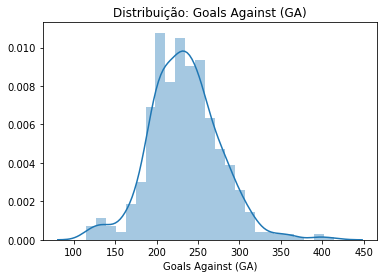

In [23]:
univariada(hockey_completo['Goals Against (GA)'])

Resumo:
Número de observações não nulas: 582 | Média: 234.06357388316152 | Desvio Padrão: 40.548915399123885 | Assimetria: 0.2488055599817491 | Curtose: 1.153962538877371
Mínimo: 115.0 | Primeiro Quartil: 211.0 | Mediana: 231.0 | Terceiro Quartil: 254.0 | Percentil 90: 282.9 | Máximo: 369.0
H0 rejeitado: há evidência de que a distribuição não é normal
P-valor do teste de Kolmogorov–Smirnov: 0.006779616709723314


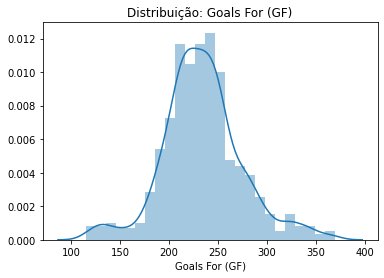

In [24]:
univariada(hockey_completo['Goals For (GF)'])

Como esperado, as médias dos gols feitos e dos gols tomados são iguais: todo o gol marcado por um time foi tomado por outro + o denominador é o mesmo (no de observações). <br> 
As outras métricas não são iguais. Em especial se verifica que:
  - O que mais parece saltar aos olhos é que a distribuição de gols feitos não parece ser normal (com p-valor < 1% 😮)
  - A distribuição dos gols feitos (GF) tem "cauda longa" quando comparada com os gols tomados (GA). "Cauda longa" é algo que se mostra comum em distribuições com desigualdades mais importantes. **Isso parece indicar que poucos times/temporada concentram a muitos dos gols**. (Exemplificando isso: distribuição de altura (normal) vs distribuição de livros vendidos por autor (cauda longa) (poucos autores concentram a maior parte das vendas de livros)). 
  - As duas distribuições são assimétricas para a esquerda (mediana menor que a média). Uma coisa interessante de se perceber é que a distribuição de gols feitos (GF) é menos assimétrica do que a de gols tomados (GA) (0.24 vs 0.32). Isso poderia ser explicado pelo fato de GF ter uma "cauda gorda" na direita (que ajuda a compensar a assimetria) - efeito direto da "desigualdade" comentada antes.  
<br>
Vamos fazer uma análise apenas por time ao invés de time/temporada e ver o que conseguimos descobrir...

In [25]:
times = hockey_completo.drop(columns=['Team Name'])
times = times.groupby(['Team']).mean()

Resumo:
Número de observações não nulas: 27 | Média: 225.2469135802469 | Desvio Padrão: 14.887560003629375 | Assimetria: -0.2793821227773841 | Curtose: -0.572176741146083
Mínimo: 192.55555555555554 | Primeiro Quartil: 215.8888888888889 | Mediana: 224.22222222222223 | Terceiro Quartil: 237.05555555555554 | Percentil 90: 245.24444444444447 | Máximo: 248.0
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.9718301042828155


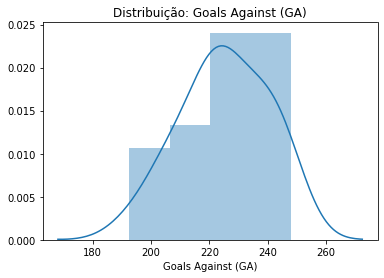

In [26]:
univariada(times['Goals Against (GA)'])

Resumo:
Número de observações não nulas: 27 | Média: 226.2551440329218 | Desvio Padrão: 15.248303030606866 | Assimetria: -0.4045125888556215 | Curtose: 0.5456686893548581
Mínimo: 187.33333333333334 | Primeiro Quartil: 217.33333333333331 | Mediana: 225.22222222222223 | Terceiro Quartil: 237.55555555555554 | Percentil 90: 241.7111111111111 | Máximo: 257.6666666666667
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.9663424460622655


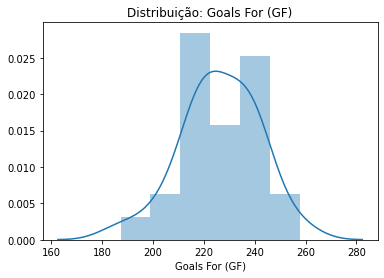

In [27]:
univariada(times['Goals For (GF)'])

Interessante.... <br>
Quando agrupamos por time, ambas assimetrias ficam negativas (mediana maior que média). GF perde a falta de normalidade. Isso me sugere que talvez a interação entre time e temporada possa ter uma influência. Intuitivamente, isso poderia fazer sentido... Pensando num exemplo mais próximo, no futebol um certo time pode estar "bem" em um ano e "mal" no outro <br>
Infelizmente 😪 temos muitas combinações de anos e times, o que faz com que esse dataset em específico não possua observações o suficiente para montar um design fatorial. Não podemos calcular o efeito de interação entre Ano e Time 😓😓😓😓. No máximo dá pra ver se time e ano (enquanto efeitos principais) tem influência.

In [28]:
anova_df = hockey_completo[['Goals For (GF)', 'Goals Against (GA)', 'Year', 'Team']]
anova_df = anova_df.astype({'Year': 'category', 'Team': 'category'})
anova_df = anova_df.rename({'Goals For (GF)': 'GF', 'Goals Against (GA)': 'GA'}, axis='columns')
anova_df = anova_df.dropna()
anova_df.columns

Index(['GF', 'GA', 'Year', 'Team'], dtype='object')

**Para o GA** <br>
Usando 1-way ANOVA (paramétrico)

In [29]:
model = ols('GA ~ C(Year)', data=anova_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 9
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
C(Year),2.827246e+07,21.0,2028.196299,3.469688e-212
Residual,1.513454e+05,228.0,NaN,NaN


In [30]:
model = ols('GA ~ C(Team)', data=anova_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 26
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
C(Team),52064.502002,28.0,2.990558,0.000007
Residual,130572.222222,210.0,NaN,NaN


No caso de gols tomados, obtemos p-valores baixos, o que quer dizer que existe diferenciação da média de gols tomados tanto por ano quanto por time.
<br>
Podemos observar isso de forma mais explícita nos gráficos abaixo.

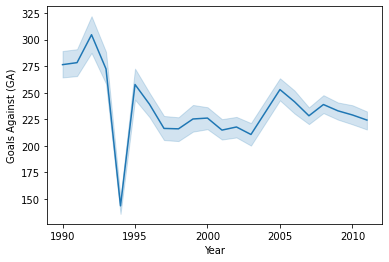

In [31]:
ax = sns.lineplot(x =hockey_completo["Year"],y=hockey_completo["Goals Against (GA)"])

Os anos fazem diferença e....

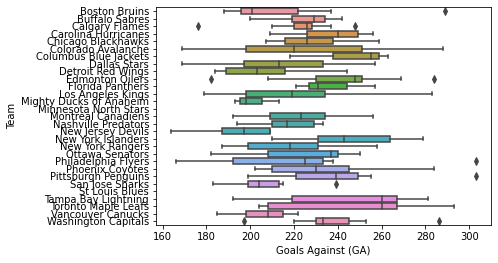

In [37]:
sns.boxplot(
    data=hockey_completo,
    x='Goals Against (GA)',
    y='Team')

... alguns times claramente são piores do que outros, levando mais gols.

**Para o GF** <br>
Usando Kruskal-Wally (não paramétrico)

In [42]:
def faz_kruskal(target, fator):
  niveis = fator.unique()
  dfs = []
  for nivel in niveis:
    df = fator[fator == nivel]
    dfs.append(df)
  return stats.kruskal(*dfs)

In [43]:
faz_kruskal(anova_df['GF'], anova_df['Year'])

KruskalResult(statistic=235.9999999999999, pvalue=1.591597615546794e-46)

In [44]:
faz_kruskal(anova_df['GF'], anova_df['Team'])

KruskalResult(statistic=235.9999999999999, pvalue=9.585620757974422e-36)

Novamente, ambos fatores se mostraram ter diferenças quanto ao numero de gols, nesse caso marcados.


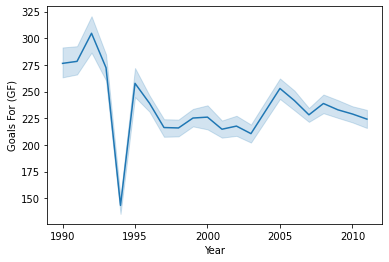

In [46]:
ax = sns.lineplot(x =hockey_completo["Year"],y=hockey_completo["Goals For (GF)"])

Como esperado, o lineplot é igual ao gols marcados contra

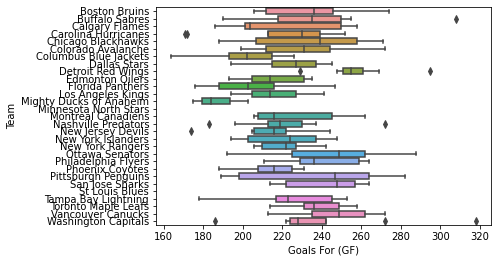

In [48]:
sns.boxplot(
    data=hockey_completo,
    x='Goals For (GF)',
    y='Team')

### Avaliando Torcedores

Resumo:
Número de observações não nulas: 290 | Média: 17.01251379310345 | Desvio Padrão: 2.1779020987436986 | Assimetria: -0.25877393288220735 | Curtose: -0.38452129211541664
Mínimo: 11.059000000000001 | Primeiro Quartil: 15.433 | Mediana: 17.2105 | Terceiro Quartil: 18.566 | Percentil 90: 19.557299999999998 | Máximo: 22.247
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.15667225683836117


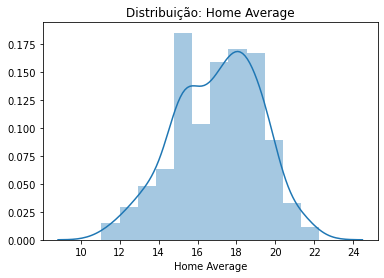

In [52]:
univariada(hockey_completo['Home Average'])

Resumo:
Número de observações não nulas: 290 | Média: 696.8628275862069 | Desvio Padrão: 89.09544144928424 | Assimetria: -0.2665327190482935 | Curtose: -0.3657730153208898
Mínimo: 453.45599999999996 | Primeiro Quartil: 632.7797499999999 | Mediana: 703.7660000000001 | Terceiro Quartil: 760.9150000000001 | Percentil 90: 801.8510000000001 | Máximo: 912.155
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.2098426542132237


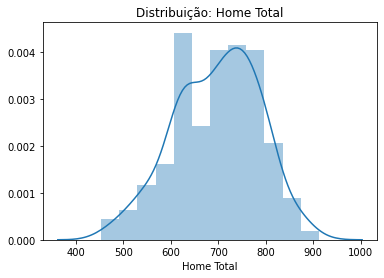

In [53]:
univariada(hockey_completo['Home Total'])

Resumo:
Número de observações não nulas: 290 | Média: 16.948351724137932 | Desvio Padrão: 0.5897077398361179 | Assimetria: 0.17295389387770885 | Curtose: 0.11778464126781829
Mínimo: 15.575 | Primeiro Quartil: 16.567500000000003 | Mediana: 16.9565 | Terceiro Quartil: 17.317 | Percentil 90: 17.7078 | Máximo: 19.002
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.895744129327577


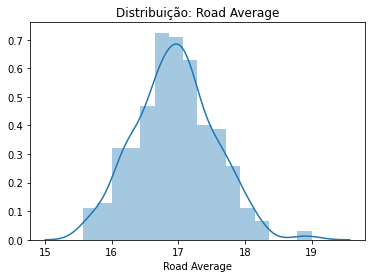

In [54]:
univariada(hockey_completo['Road Average'])

Resumo:
Número de observações não nulas: 290 | Média: 16.98043793103448 | Desvio Padrão: 1.1915516495328078 | Assimetria: -0.12323875460076363 | Curtose: -0.4481953363176667
Mínimo: 14.026 | Primeiro Quartil: 16.096 | Mediana: 17.0185 | Terceiro Quartil: 17.87825 | Percentil 90: 18.3645 | Máximo: 19.896
H0 não rejeitado: Não há evidência de que a distribuição não seja normal - vamos considerar normal
P-valor do teste de Kolmogorov–Smirnov: 0.4164846214400496


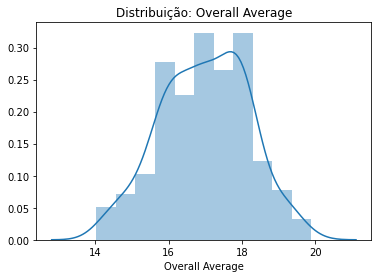

In [56]:
univariada(hockey_completo['Overall Average'])

### Análise Multivariada